In [4]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import colormaps as cmaps
import os
import scipy as sp
from scipy.ndimage.interpolation import rotate
from magpie_data import PolarimetryMap2, FaradayMap2, NeLMap2, Interferogram, OpticalFrames
import scipy.constants as c
from mcerp import N, umath, Gamma
import pickle

# Harris Sheet

In [69]:
%cd "~\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat\s0513_15"
B0fn="13-May-2015 16_39_56_1355463638_fliplr.png"
B1fn="13-May-2015 16_39_56_2211629970.png"
S0fn="13-May-2015 17_00_09_1355463638_fliplr.png"
S1fn="13-May-2015 17_00_09_2211629970.png"
s0513_15_pol=PolarimetryMap2(B0fn, B1fn, B0fn, B1fn, S0fn, S1fn)
s=s0513_15_pol

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat\s0513_15


In [70]:
t=pickle.load(open("s0513_16 faraday registration.txt", "rb"))
s.register(transform=t)

C:\Users\jdhare\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [71]:
s.convert_to_alpha()
s.scale=67
s.set_origin([1255,1682], extent=[-13,13,-6,6])

In [72]:
%cd "~\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat"
s0513_15_far=FaradayMap2(s0513_15_pol,
                         "s0513_15 IR side on image registration flipud.jpg", 
                         "s0513_15 neL side on.txt", 
                         flip_ne=True)

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat


In [73]:
f=s0513_15_far
t=pickle.load(open('s0513_15 interferometry transform.txt', 'rb'))
f.register(transform=t)

C:\Users\jdhare\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [74]:
f.scale=s.scale
f.set_origin(s.origin, extent=[-13,13,-6,6])

In [75]:
s0513_15_ne=NeLMap2('s0513_15 neL side on.txt', scale=s.scale) 
ne=s0513_15_ne
ne.data=f.I1T
ne.scale=s.scale
ne.set_origin(origin=s.origin, extent=[-13,13,-6,6])

In [134]:
xx=4.2
zz=0 #note the the data files are flipped ud wrt to the images, so think about the sign here!
lw=2*s.scale

f.create_lineout(start=(zz,-xx), end=(zz, xx), lineout_width=lw)

from lmfit import Model
def Harris(x, x0, B0, delta,C):
    return B0*np.tanh((x-x0)/delta)+C

hm=Model(Harris, independent_vars='x')
hm.set_param_hint('B0', value = 2)
hm.set_param_hint('x0', value = 0)
hm.set_param_hint('delta', value = 0.25)
hm.set_param_hint('C', value = 0)
res=hm.fit(f.lo, x=f.mm)

(871, 120) (871, 683)


In [135]:
x=f.mm-res.best_values['x0']
B=f.lo-res.best_values['C']
hm=Model(Harris, independent_vars='x')
hm.set_param_hint('B0', value = 2)
hm.set_param_hint('x0', value = 0)
hm.set_param_hint('delta', value = 0.25)
hm.set_param_hint('C', value = 0)
res_0=hm.fit(B, x=x)

In [140]:
def Harris_j(x, x0, B0, delta):
    return B0/(c.mu_0*delta*(np.cosh((x-x0)/delta))**2)

C=0
x0=0
B0=res_0.best_values['B0']
delta=res_0.best_values['delta']

j=Harris_j(x*1e-3,x0,B0,delta*1e-3)

<IPython.core.display.Javascript object>


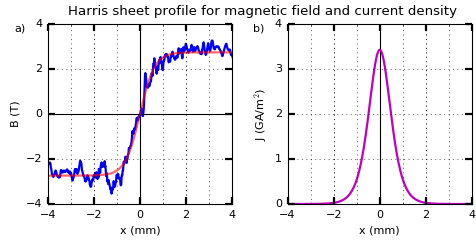

In [176]:
fig, ax = plt.subplots(1,2, sharex=True, figsize=(5.96,3))

a=ax[0]
a.plot([-4,4],[0,0], c='k')
a.plot([0,0],[-4,4], c='k')
a.plot(x, B, lw=2, c='blue', label='Magnetic Field')
a.plot(x, res_0.best_fit, lw=2, c='red', alpha=0.6, label='Harris Sheet')
a.set_yticks([-4,-2,0,2,4])

a.set_ylabel('B (T)', fontsize=10)

a=ax[1]
a.plot([0,0],[-4,4], c='k')
a.plot(x, j/1e9, lw=2, c='m', label='Current Density')
a.set_ylim([0,4])
a.set_yticks([0,1,2,3,4])
a.set_ylabel(r'J (GA/m$^2$)', fontsize=10)


for a in ax:
    a.tick_params(labelsize=10, pad=5, length=6, width=2)
    a.grid(True)
    a.set_xlabel("x (mm)", fontsize=10)
    a.set_xlim([-4,4])
    a.set_xticks([-4,-2,0,2,4])
    a.xaxis.set_minor_locator(MultipleLocator(1))
    a.grid(which='minor')
    #a.legend(fontsize=10)

fig.subplots_adjust(left=0.1, bottom=0.15, right=0.99, top=0.9,
                wspace=0.3, hspace=0.1)

fig.suptitle(r'Harris sheet profile for magnetic field and current density', fontsize=12, x=0.55)

fig.text(0.03, 0.87,"a)", fontsize=10)
fig.text(0.53, 0.87,"b)", fontsize=10)

In [308]:
J.max()

3419538.7896773666

In [177]:
print(res_0.fit_report())

[[Model]]
    Model(Harris)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 564
    # variables        = 4
    chi-square         = 48.671
    reduced chi-square = 0.087
    Akaike info crit   = -1373.786
    Bayesian info crit = -1356.446
[[Variables]]
    x0:      6.2190e-05 +/- 0.010338 (16623.54%) (init= 0)
    B0:      2.73986502 +/- 0.015186 (0.55%) (init= 2)
    delta:   0.63629139 +/- 0.017984 (2.83%) (init= 0.25)
    C:       3.4962e-05 +/- 0.014145 (40460.68%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(x0, C)                     =  0.477 
    C(B0, delta)                 =  0.456 



In [178]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter6_harris_profiles.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

# Electric Field

In [90]:
cd "~\Google Drive\MAGPIE\data\2015\s0611_15"

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s0611_15


In [103]:
import csv
x_pos=[]
n_e=[]
Z=[]
T_e=[]
T_e_err=[]
T_i=[]
T_i_err=[]
V=[]
V_err=[]

filename='s0611_15 TS fits v3.dat'
with open(filename, 'r') as fn:
    reader = csv.reader(fn, delimiter='\t')
    next(reader)
    for row in reader:
        x_pos.append(float(row[3]))
        n_e.append(float(row[5]))
        Z.append(float(row[6]))
        T_e.append(float(row[7]))
        tee=float(row[8])
        if tee==0:
            T_e_err.append(float(row[7])/10.0)
        else:
            T_e_err.append(tee)
        T_i.append(float(row[9]))
        tie=float(row[10])
        if tie==0:
            T_i_err.append(float(row[9])/10.0)
        else:
            T_i_err.append(tie)
        V.append(float(row[11]))
        ve=float(row[12])
        if tie==0:
            V_err.append(float(row[11])/10.0)
        else:
            V_err.append(ve)
        
x_ts=np.array(x_pos)
n_e=np.array(n_e)*1e6
n_e_err=(np.zeros_like(n_e)+0.3e17)*1e6 
Z=np.array(Z)
T_e=np.array(T_e)
T_e[11]=15 #set to avg.
T_e_err=np.array(T_e_err)
T_i=np.array(T_i)
T_i_err=np.array(T_i_err)
V=np.array(V)*1e3
V_err=np.array(V_err)*1e3 

In [215]:
E0=50e3*B0

In [166]:
B_ohm=Harris(x_ts,x0,B0,delta,C)
J_ohm=Harris_j(x_ts*1e-3,x0,B0,delta*1e-3)

In [167]:
def col_log_eis(T_e,n_e,Z):
    if T_e<10*Z**2: #see NRL formulary pg 34
        col_log=23-np.log((n_e*1e-6)**0.5*Z*T_e**-1.5)
    else:
        col_log=24-np.log((n_e*1e-6)**0.5*T_e**-1.0)
    return col_log
col_log_ei=np.vectorize(col_log_eis)

eta=1.03e-2*Z*col_log_ei(T_e,n_e,Z)*T_e**-1.5 #ohm cm
eta=eta*1e-2#ohm m

<IPython.core.display.Javascript object>


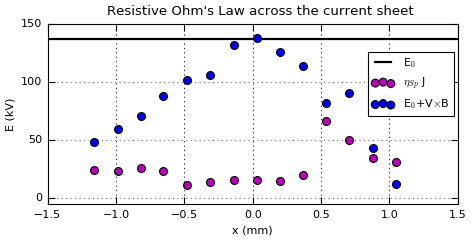

In [216]:
fig, ax=plt.subplots(figsize=(5.96,3))

ax.plot([-2,2], [E0/1e3, E0/1e3], c='k', label=r'E$_0$', lw=2,)
ax.scatter(x_ts, eta*J_ohm/1e3, s=50,label=r'$\eta_{Sp}$ J', c='m')
ax.scatter(x_ts, (E0+V*B_ohm)/1e3, s=50, label=r'E$_0$+V$\times$B', c='blue',zorder=6)

ax.legend(fontsize=10, loc=(0.78,.49))


a=ax
a.tick_params(labelsize=10, pad=5, length=6, width=1)
a.grid(True)
a.set_xlabel("x (mm)", fontsize=10)
a.set_xlim([-1.5,1.5])
a.set_xticks([-1.5,-1,-0.5,0,0.5,1,1.5])
a.xaxis.set_minor_locator(MultipleLocator(0.5))
a.grid(which='minor')

a.set_ylim([-5,150])
a.set_yticks([0,50,100,150])
a.set_ylabel(r'E (kV)', fontsize=10)

fig.subplots_adjust(left=0.1, bottom=0.15, right=0.96, top=0.9,
                wspace=0.3, hspace=0.1)

fig.suptitle(r"Resistive Ohm's Law across the current sheet ", fontsize=12, x=0.55)



In [212]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter6_ohms_law.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

In [218]:
B_ohm

array([-2.60131119, -2.50519828, -2.35388324, -2.11659319, -1.74675701,
       -1.24570788, -0.58807417,  0.12436509,  0.82034138,  1.43482607,
        1.88604258,  2.20137457,  2.41419879,  2.5427834 ])

# Power Balance

In [220]:
#Energies in J/m^3
m_i=12*c.m_n
B=N(3,0.3)
V_in=N(50e3,5e3)
n_e=N(3e17, 0.6e17)*1e6#m^3
Z=4
n_i=n_e/Z
T_e=N(15,3)*11604#K
T_i=N(50,5)*11604#K

E_kin_in=0.5*m_i*n_i*V_in**2
E_mag_in=B**2/(2*c.mu_0)
E_thi_in=1.5*c.k*n_i*T_i
E_the_in=1.5*c.k*n_e*T_e

L=N(7e-3,1e-3)

V_out=N(130e3,5e3)
n_e=N(6e17, 0.6e17)*1e6#m^3
B=0
Z=6
n_i=n_e/Z
T_e=N(100,10)*11604#K
T_i=N(600,60)*11604#K

E_kin_out=0.5*m_i*n_i*V_out**2
E_thi_out=1.5*c.k*n_i*T_i
E_the_out=1.5*c.k*n_e*T_e

d=N(0.6e-3, 0.1e-3)

E_in=np.array([E_mag_in, E_kin_in, E_thi_in, E_the_in])
E_out=np.array([0,E_kin_out, E_thi_out, E_the_out])

rate_in=L*V_in*16e-3
rate_out=d*V_out*16e-3

P_in=E_in*rate_in
P_out=E_out*rate_out

data=np.array([[pin.mean,pout.mean] for pin,pout in zip(P_in,P_out)])
std=np.array([[pin.std,pout.std] for pin,pout in zip(P_in,P_out)])

#data = np.array([1e-6*rate_in*E_in,1e-6*rate_out*E_out])
colors = ('red', 'orange', 'purple', '#3333FF')
labels=[r'$P_{mag}$', '$P_{kin}$',r'$P_{th, i}$',r'$P_{th,e}$']

<IPython.core.display.Javascript object>


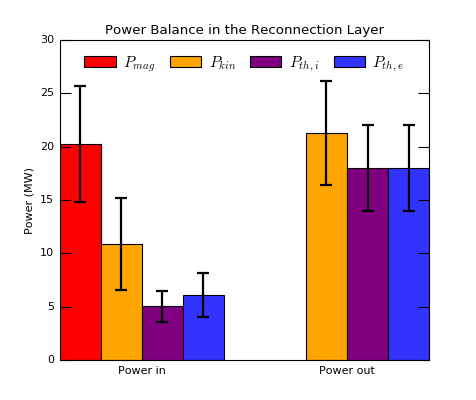

In [259]:
fig, ax=plt.subplots(figsize=(5.96,5))

ekw={'ecolor':'black', 'elinewidth':2, 'capsize':5, 'capthick':2}

width=0.1
ind=np.array([0,0.5])

ax.bar([0], data[0,0]/1e6,width,yerr=std[0,0]/1e6,color=colors[0], label=labels[0], error_kw=ekw)

for i in range(1,4):
    ax.bar(ind+i*width, data[i]/1e6,width,yerr=std[i]/1e6,color=colors[i], label=labels[i], error_kw=ekw)

ax.set_xticks([0.2,0.7])
ax.set_xticklabels(['Power in','Power out'])
ax.set_xlim(0,0.9)

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

ax.set_ylim([0,30])
ax.set_ylabel('Power (MW)', fontsize=10)
ax.tick_params(labelsize=10, pad=5, length=10, width=1)


ax.legend(loc=9, 
          ncol=4, 
          fontsize=14, 
          frameon=False, 
          columnspacing=0.9,
          numpoints=1, 
          handletextpad=0.5, 
          handlelength=2)

ax.set_title('Power Balance in the Reconnection Layer', fontsize=12)

In [260]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter6_power_balance.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

# Viscous Heating Calculations

In [300]:
A=12
Z=6
n_e=6e17
n_i=n_e/Z
col_log_ei=5
dV_ydx=1e7/0.06

alpha=1.5e7/(Z**3*n_e)*2/3*dV_ydx**2
#alpha=2e6/1e18*2/3*dV_ydx**2

T0=50
c=2/3*(1/T0)**(3/2)

def T(t):
    return ((2/3)/(c-alpha*t))**(2/3)

t=np.linspace(0,1e-6,1000)

<IPython.core.display.Javascript object>


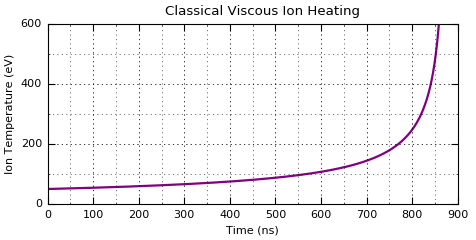

In [301]:
fig, ax=plt.subplots(figsize=(5.96,3))
ax.plot(t*1e9, T(t), lw=2, c='purple')
ax.set_ylim([0,600])

a=ax
a.tick_params(labelsize=10, pad=5, length=6, width=1)
a.grid(True)
a.set_xlabel("Time (ns)", fontsize=10)
a.xaxis.set_minor_locator(MultipleLocator(50))
a.yaxis.set_minor_locator(MultipleLocator(100))

a.grid(which='minor')

a.set_ylim([0,600])
a.set_yticks([0,200,400,600])
a.set_ylabel(r'Ion Temperature (eV)', fontsize=10)

fig.subplots_adjust(left=0.1, bottom=0.15, right=0.96, top=0.9,
                wspace=0.3, hspace=0.1)

fig.suptitle(r"Classical Viscous Ion Heating", fontsize=12, x=0.55)


In [302]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter6_viscous_heating.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

# Radiative Cooling

In [261]:
cd "~\Google Drive\MAGPIE\data\SPK data"

C:\Users\jdhare\Google Drive\MAGPIE\data\SPK data


In [262]:
fn='cooling_curve_C_1e17_NLTE.txt'
d=np.genfromtxt(fn, skip_header=1)
Temperatures=d[:,0]
Intensities=d[:,1]

<IPython.core.display.Javascript object>


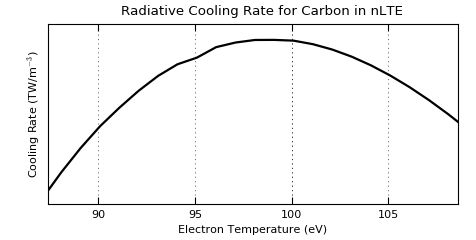

In [276]:
fig, ax=plt.subplots(figsize=(5.96,3))
ax.plot(Temperatures, Intensities/1e12, lw=2, c='black')

a=ax
a.tick_params(labelsize=10, pad=5, length=6, width=1)
a.grid(True)
a.set_xlabel("Electron Temperature (eV)", fontsize=10)
a.xaxis.set_minor_locator(MultipleLocator(100))
a.yaxis.set_minor_locator(MultipleLocator(5))
a.grid(which='minor')

a.set_ylim([0,30])
a.set_yticks([0,10,20,30])
a.set_ylabel(r'Cooling Rate (TW/m$^{-3}$)', fontsize=10)

fig.subplots_adjust(left=0.1, bottom=0.15, right=0.96, top=0.9,
                wspace=0.3, hspace=0.1)

fig.suptitle(r"Radiative Cooling Rate for Carbon in nLTE", fontsize=12, x=0.55)


In [277]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter6_cooling_rate.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

In [280]:
T_e=100
I=Intensities[np.where(T_e<Temperatures)[0][0]]

n_e=6e17
U=1.5*n_e*T_e*1.6e-19*1e6#eV cm^-3 -> J m^-3
tau=U/I

# Ohmic Heating

In [311]:
Z=6
col_log_ei=5
j=3e9
n_e=6e17

A=1e-4*Z*col_log_ei*j**2/(1.5*n_e*1e6)/1.6e-19

T_0=15
c=(T_0/1.44)**(5/2)

def T(t):
    return 1.44*(A*t+c)**(2/5)

<IPython.core.display.Javascript object>


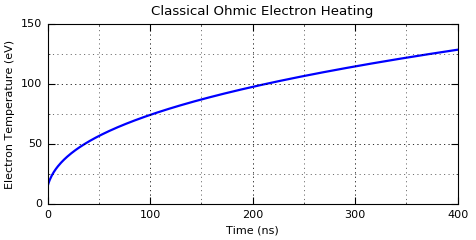

In [312]:
fig, ax=plt.subplots(figsize=(5.96,3))
ax.plot(t*1e9, T(t), lw=2, c='blue')
ax.set_ylim([0,600])

a=ax
a.tick_params(labelsize=10, pad=5, length=6, width=1)
a.grid(True)
a.set_xlabel("Time (ns)", fontsize=10)
a.xaxis.set_minor_locator(MultipleLocator(50))
a.yaxis.set_minor_locator(MultipleLocator(25))

a.grid(which='minor')
a.set_ylim([0,150])
a.set_yticks([0,50,100,150])
a.set_ylabel(r'Electron Temperature (eV)', fontsize=10)

a.set_xlim([0,400])
a.set_xticks([0,100,200,300,400])


fig.subplots_adjust(left=0.1, bottom=0.15, right=0.96, top=0.9,
                wspace=0.3, hspace=0.1)

fig.suptitle(r"Classical Ohmic Electron Heating", fontsize=12, x=0.55)


In [306]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter6_ohmic_heating.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

# Ion Acoustic Instability

In [315]:
cd "~\Google Drive\MAGPIE\data\2015\s0611_15"

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s0611_15


In [316]:
#Fibre,X positions,Y Positions,Y wrt Shock,Length along porbing line,n_e, 6:n_e corrected, 7:T_e, 8:T_i, 9:Z, 10:V_f_par, 11:V_f_per
x_pos=[]
Z=[]
T_e=[]
T_i=[]

filename='s0611_15 TS fits v3.dat'
with open(filename, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    next(reader)
    for row in reader:
        x_pos.append(float(row[3]))
        Z.append(float(row[6]))
        T_e.append(float(row[7]))
        T_i.append(float(row[9]))
        
x_TS=np.array(x_pos)
Z=np.array(Z)
T_e=np.array(T_e)
T_i=np.array(T_i)
A=12
C_IA=(9.79e5*A**-0.5*(Z*T_e+T_i)**0.5)*1e-2 #m/s

In [353]:
ne.create_lineout(start=(0,-3), end=(0,3))
#s0513_15_532.plot_lineout()
ne_interp=np.interp(x_TS, ne.mm, ne.lo)
length=2.1 #cm
u_ed=J*1e3/(ne_interp*1e6/length*1.6e-19) #m/s

(871, 201) (871, 603)


<IPython.core.display.Javascript object>


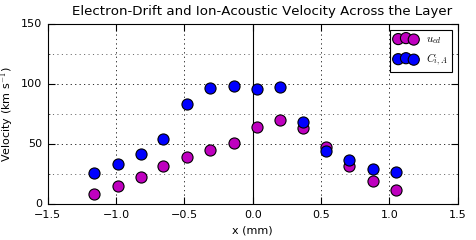

In [357]:
fig, ax=plt.subplots(figsize=(5.96,3))

ax.plot([0,0], [0, 150], c='k', lw=1,)
ax.scatter(x_TS, u_ed/1e3, s=100,label=r'$u_{ed}$', c='m', zorder=6)
ax.scatter(x_TS, C_IA/1e3, s=100, label=r'$C_{i,A}$', c='blue',zorder=6)

ax.legend(fontsize=12)


a=ax
a.tick_params(labelsize=10, pad=5, length=6, width=1)
a.grid(True)
a.set_xlabel("x (mm)", fontsize=10)
a.set_xlim([-1.5,1.5])
a.set_xticks([-1.5,-1,-0.5,0,0.5,1,1.5])
a.xaxis.set_minor_locator(MultipleLocator(0.5))
a.yaxis.set_minor_locator(MultipleLocator(25))

a.grid(which='minor')

a.set_ylim([0,150])
a.set_yticks([0,50,100,150])
a.set_ylabel(r'Velocity (km s$^{-1}$)', fontsize=10)

fig.subplots_adjust(left=0.1, bottom=0.15, right=0.96, top=0.9,
                wspace=0.3, hspace=0.1)

fig.suptitle(r"Electron-Drift and Ion-Acoustic Velocity Across the Layer",fontsize=12, x=0.55)

In [358]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter6_ion_acoustic_instability.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

# Plasmoids

In [359]:
%cd "~\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow"

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow


In [360]:
s1006_15_532=NeLMap2('s1006_15 532nm neL.txt', scale=173, multiply_by=1/1.6, rot_angle=-90)
s1006_15_532.set_origin(origin=(2328,1421), extent=[-11.5,11.5,-8,8])
s1006_15_355=NeLMap2('s1006_15 355nm neL.txt', scale=128, multiply_by=2/1.6, rot_angle=-90,flip_lr=True)
s1006_15_355.set_origin(origin=(1680,1113), extent=[-11.5,11.5,-8,8])

C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


<IPython.core.display.Javascript object>


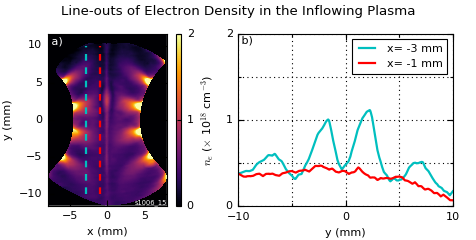

(3719, 865) (259, 865)
(3719, 1211) (259, 1211)


In [437]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Palatino"


fs=10

fig=plt.figure(figsize=(5.96,3))
ax1=fig.add_axes([0.1, 0.10, 0.25, 0.8])#l,b,w,h
gim=s1006_15_532.plot_data_mm(ax=ax1, clim=[0,2], multiply_by=1e-18)

for x_mm in [-2.9,-1]:
    ax1.plot([x_mm,x_mm],[-10,10], lw=2, ls='dashed')
ax1.lines[0].set_color('c')
ax1.lines[1].set_color('red')


ax1.set_xlabel('x (mm)',fontsize=fs)
ax1.set_ylabel('y (mm)',fontsize=fs)
ax2.set_xlabel('x (mm)',fontsize=fs)
ax1.set_xticks([-5,0,5])

ax1.set_xlim([-8,8])
ax1.set_ylim([-11.5,11.5])

ax1.tick_params(labelsize=fs, pad=5, length=5, width=1)

cbar_ax=fig.add_axes([0.37, 0.14, 0.01, 0.72])#l,b,w,h
cbar_ax.tick_params(labelsize=fs, pad=5, length=4, width=1)

fig.colorbar(gim, cax=cbar_ax, ticks=[0.0,1,2])
cbar_ax.set_ylabel(r'$n_e$ ($\times$ 10$^{18}$ cm$^{-3}$)',fontsize=fs)

c3w=0.45
c3l=0.5

ax3=fig.add_axes([c3l, 0.14, c3w, 0.72])#l,b,w,h
s=s1006_15_532

multiply_by=1e-18
x_mm=-3
s.create_lineout(start=(-10,x_mm),end=(10,x_mm), lineout_width=0.2*s.scale)
ax3.plot(s.mm, s.lo*multiply_by, label="x= "+str(x_mm)+" mm", lw=2, c='c')  

x_mm=-1
s.create_lineout(start=(-10,x_mm),end=(10,x_mm), lineout_width=0.2*s.scale)
ax3.plot(s.mm, s.lo*multiply_by, label="x= "+str(x_mm)+" mm", lw=2, c='red')  

ax3.set_xticks([-10,0,10])
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.set_ylim([0, 2])
ax3.set_yticks([0, 1,2])
ax3.yaxis.set_minor_locator(MultipleLocator(0.5))

#ax3.grid(which='major', linewidth=2)
ax3.grid(which='minor', linewidth=1)

ax3.set_axisbelow(True)

ax3.tick_params(which='minor', pad=5, length=3, width=1)
ax3.tick_params(labelsize=fs, pad=5, length=5, width=1)

ax3.set_xlabel('y (mm)',fontsize=fs)
ax3.set_xlim([-10,10])

ax3.legend(fontsize=10)

fig.suptitle('Line-outs of Electron Density in the Inflowing Plasma', fontsize=12)

ax1.text(x=0.0, y=0.99, va='top',ha='left',s=r' a)', color='white',fontsize=10,transform=ax1.transAxes)
ax1.text(x=1, y=0.0, va='bottom',ha='right',s=r's1006_15', color='white',fontsize=6,transform=ax1.transAxes)

ax3.text(x=0.0, y=0.99, va='top',ha='left',s=r' b)', color='black',fontsize=10,transform=ax3.transAxes)


In [434]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter6_initial_perturbations.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

In [436]:
plt.rcParams["font.serif"]

['palatino']